In [1]:
import pandas as pd
import numpy as np
# import warnings
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt


# ignore warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

## Primeiros Passos

- Este banco de dados possui informações sobre veículos usados (Preço, ano, modelo, marca, etc);
- Usaremos esses dados para construir um modelo, através de aprendizado de máquina, capaz de prever o valor de um carro com base nas suas características

### Importando os dados

In [2]:
audi = pd.read_csv('./input/audi.csv')
bmw = pd.read_csv('./input/bmw.csv')
cclass = pd.read_csv('./input/cclass.csv')
focus = pd.read_csv('./input/focus.csv')
ford = pd.read_csv('./input/ford.csv')
hyundi = pd.read_csv('./input/hyundi.csv')
merc = pd.read_csv('./input/merc.csv')
skoda = pd.read_csv('./input/skoda.csv')
toyota = pd.read_csv('./input/toyota.csv')
vauxhall =  pd.read_csv('./input/vauxhall.csv')
vw = pd.read_csv('./input/vw.csv')

### Limpeza e ajuste nos dados

- Irei criar variáveis para receber o nome das colunas(pois existem colunas com pequenas diferenças no nome), além de variáveis para receber o nome de cada uma das marcas, afim de unir todos os bancos de dados em somente um.

In [3]:
brand = [audi, bmw, cclass, focus, ford, hyundi, merc, skoda, toyota, vauxhall, vw]
brand1 = ['audi', 'bmw', 'cclass', 'focus', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw']
columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize']

- Agora, incluirei dados que estão faltando e atribuirei o nome das colunas nos bancos de dados:

In [4]:
cclass['tax'] = audi.tax.mean()
cclass['mpg'] = audi.mpg.mean()
focus['tax'] = bmw.tax.mean()
focus['mpg'] = bmw.mpg.mean()
cclass = cclass[columns]
focus = focus[columns]

- Então, criarei uma nova coluna que receberá a marca do automóvel em questão
- Em seguida, unirei todos os bancos de dados

In [5]:
for k, i in enumerate(brand):
    i['brand'] = brand1[k]
cclass['brand'] = 'cclass'
focus['brand'] = 'focus'

In [6]:
columns = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'brand']
for k, i in enumerate(brand):
    i.columns = columns
df = pd.concat(brand)

- Vamos dar uma olhada no banco de dados:

In [7]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108540 entries, 0 to 15156
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           108540 non-null  float64
 7   mpg           108540 non-null  float64
 8   engineSize    108540 non-null  float64
 9   brand         108540 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 9.1+ MB


## Análise exploratória de dados (AED)

- Vamos analisar a quantidade de marcas pelo banco de dados;
- Em seguida, verificaremos a distribuição dos preços.

Text(0, 0.5, 'Quantidade')

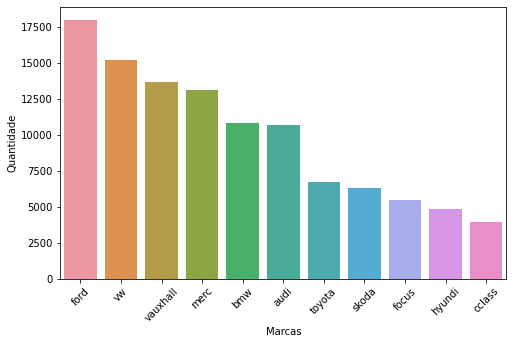

In [9]:
state = df['brand'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x=state.index, y=state.values)
plt.xticks(rotation=45)
plt.xlabel('Marcas')
plt.ylabel('Quantidade')

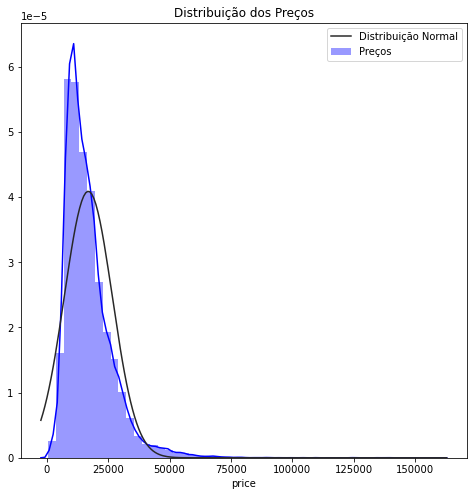

In [10]:
plt.figure(figsize=(8,8))
plt.title('Distribuição dos Preços')
sns.distplot(df['price'], kde=True, color='blue', fit=stats.norm)
plt.legend(['Distribuição Normal', 'Preços'])

Algumas análises possiveis:
- A marca ford e a vw são encontradas em maior quantidade neste banco de dados
- Os preços se mantem principalmente na região entre 0 ~ 50mil

## Aplicando transformações

Afim de construir um modelo de aprendizado de máquinas, algumas transformações serão necessárias:
- Transformar variáveis categóricas em numéricas;
- Restringir valores muito elevados(como preço e quilometragem) para um intervalo entre 0 e 1;
    - Isto serve para que valores elevados de uma coluna não tenham um peso maior em relação a valores menores de outras colunas
- Por último, dividir o banco de dados em 2 conjuntos: Treino e teste
    - Essa divisão serve para fazer a avaliação do desempenho do modelo

In [11]:
#Transformando variáveis categóricas em numéricas
from sklearn.preprocessing import LabelEncoder

cat_features = ['model', 'transmission', 'fuelType', 'brand']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = df[cat_features].apply(encoder.fit_transform)

In [12]:
data = df[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']].join(encoded)
data.head()

,year,price,mileage,tax,mpg,engineSize,model,transmission,fuelType,brand
0,2017,12500,15735,150.0,55.4,1.4,9,1,4,0
0,2017,12500,15735,150.0,55.4,1.4,4,0,0,1
0,2017,12500,15735,150.0,55.4,1.4,32,0,0,2
0,2017,12500,15735,150.0,55.4,1.4,61,1,4,3
0,2017,12500,15735,150.0,55.4,1.4,60,0,4,4


In [13]:
#Ajustando os valores para o intervalo entre 0 e 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize','model', 'fuelType','brand']] = \
scaler.fit_transform(data[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize','model', 'fuelType','brand']])

In [14]:
data.head()

,year,price,mileage,tax,mpg,engineSize,model,transmission,fuelType,brand
0,0.522222,0.075525,0.048712,0.258621,0.117109,0.024823,0.046392,1,1.0,0.0
0,0.522222,0.075525,0.048712,0.258621,0.117109,0.024823,0.020619,0,0.0,0.1
0,0.522222,0.075525,0.048712,0.258621,0.117109,0.024823,0.164948,0,0.0,0.2
0,0.522222,0.075525,0.048712,0.258621,0.117109,0.024823,0.314433,1,1.0,0.3
0,0.522222,0.075525,0.048712,0.258621,0.117109,0.024823,0.309278,0,1.0,0.4


In [15]:
#Transformando em conjunto de treino e teste
N = len(data)
TRAIN_PERC = 0.80
ind_train = np.random.rand(N) < TRAIN_PERC
train, test = data[ind_train], data[~ind_train]
print(f'len(train)={len(train)}; len(test)={len(test)}')

len(train)=709058; len(test)=177284


In [16]:
X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

Todas as transformações necessárias já foram realizadas, agora podemos iniciar a Modelagem

### Modelagem

Este problema será resolvido através de técnicas de regressão, para isso utilizaremos:
- Ridge;
- Regressão Linear;
- Regressão de floresta aleatória.

Primeiramente, criarei uma variável dicionário para receber os 3 algoritmos e depois faremos a avaliação do desempenho com uma função

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

clf_dict = {
    'Ridge': Ridge,
    'LinearRegression': LinearRegression,
    'RandomForest': RandomForestRegressor
}

In [19]:
from sklearn.metrics import r2_score
import time
def get_accuracy(clf, n_estimators=None, max_depth=None, learning_rate=None, max_iter=None):
    start = time.time()
    text_clf = clf(**params).fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    print(f'{clf_str} Score gets in {r2_score(y_test, predicted)}')

result_dict = {}

for clf_str, clf_fn in clf_dict.items():
    params = {}
    accuracy = get_accuracy(clf=clf_fn, **params)
    result_dict[clf_str] = accuracy

Ridge Score gets in 0.32015619250889404
LinearRegression Score gets in 0.32015704991250027
RandomForest Score gets in 0.9877935173351794


## Conclusão

O modelo apresentado obteve uma precisão de 98% em prever o valor de um automóvel semi-novo com base nas suas características. Para chegar a esse resultado, os seguintes passos foram executados:
- Limpeza dos dados;
- Verificamos por meio de uma análise exploratória de dados algumas informações sobre o Dataset em questão;
- Aplicamos algumas transformações necessárias para a modelagem;
- Construimos o modelo no qual o algoritmo de Regressão de floresta aleatória obteve uma perfomance de 98% de acurácia.